# 房价预测

## Step1：检视源数据集

In [1]:
import numpy as np
import pandas as pd

### 读入数据

In [2]:
# 一般来说index那一栏无用，故当作第0列，不用做特征（dataFrame）
train_df = pd.read_csv('./input/train.csv', index_col=0)
test_df = pd.read_csv('./input/test.csv', index_col=0)

### 检视源数据

In [3]:
# head()默认5行
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


看到数据后，需要做预处理：
> * 数据中有很多NaN数据
> * 数据中有很多英文数据（英文变数字）
> * 数据中有很多数字本身对最后结果而言没有太大意义

## Step2：合并数据

需要对train data和test data的数据同时做处理，这样训练好的模型才能对test data 有效，故要做合并数据这一步；

我们需要把SalePrice从train data中拿出来，先看下SalePrice长什么样；

In [4]:
% matplotlib inline #魔法函数：内嵌绘图
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])}) #price+1避免等于0
prices.hist() #使用matplotlib来画出DataFrame的直方图

UsageError: unrecognized arguments: #魔法函数：内嵌绘图


label数据并不是正态分布的（平滑），故用log使数据正态化（也可以用别的方式）；

log1p = log(1+p);

如果我们这里把数据都给平滑化了，那么最后算结果的时候，要记得把预测到的平滑数据给变回去,按照“怎么来的怎么去”原则，log1p()就需要expm1(); 同理，log()就需要exp(), ... etc;

In [5]:
y_train = np.log1p(train_df.pop('SalePrice'))

In [6]:
# 把剩下的部分合并起来
all_df = pd.concat((train_df, test_df), axis=0)

In [7]:
all_df.shape

(2919, 79)

In [8]:
y_train.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

## Step3：变量转化

特征工程需要依据具体数据而定

#### 正确化变量属性

In [9]:
#这个属性数字只代表类型，没有大小关系，所以需要转为string
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str) 

In [10]:
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

#### 处理category的变量

In [11]:
# one-hot来表示category
pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [12]:
# 把all_df的数据都给one-hot
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head() #列数变多了，79->303
#all_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


#### 处理numerical数据

* 数据缺失

In [13]:
# 先把缺失数据按照类别降序打印出来 sort_values（降序）
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
dtype: int64

In [14]:
# 用平均值填补空缺
# 计算平均值
mean_cols = all_dummy_df.mean()
mean_cols.head(10)

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64

In [15]:
all_dummy_df = all_dummy_df.fillna(mean_cols)

In [16]:
all_dummy_df.isnull().sum().sum()

0

* 数据标准化

In [17]:
# 找到numeric数据
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

减去平均值，除以方差，(X-X')/s

In [18]:
numeric_mean = all_dummy_df.loc[:,numeric_cols].mean()
numeric_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols]-numeric_mean)/numeric_std

## Step4：建立模型

#### 把数据集分回 训练/测试集

In [20]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

In [21]:
X_train = dummy_train_df.values
X_test = dummy_test_df.values

#### 高级的Ensemble

一般来说，单个分类器的效果真的有限，所以倾向于把N个分类器合在一起，做一个“综合分类器”达到更好的效果

In [23]:
from sklearn.linear_model import Ridge
ridge = Ridge(15)

#### Bagging

把训练数据每次抽取一点点训练每一颗树，最后采取vote的形式决定

In [25]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score

在部署Bagging的时候，把它的函数base_estimator里填上小分类器（ridge）

In [27]:
params = [1, 10, 15, 20, 25, 30, 40]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

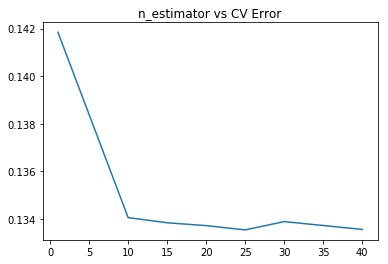

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title('n_estimator vs CV Error');

由上图可以看到，在n_estimators取25时，error可以取得最小值0.132左右

如果用Bagging自带的decisionTree，可以看看效果

In [31]:
params = [10, 15, 20, 25, 30, 40, 50, 60, 70, 100]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

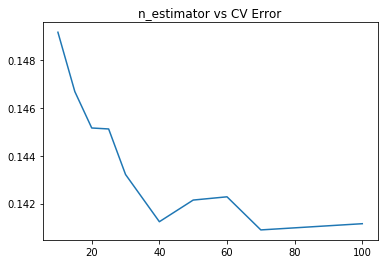

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

由上图可以看出，效果没有用ridge的好

#### Boosting

Boosting 把多个分类器线性排列，下一个分类器把上一个分类器分类的不好的地方加上更高的权重，这样下一个分类器就能在这个部分学得更加“深刻”

In [33]:
from sklearn.ensemble import AdaBoostRegressor

In [43]:
params = [1,2,3,4,5,6,7,8,9,10]
test_scores = []
for param in params:
    clf = AdaBoostRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

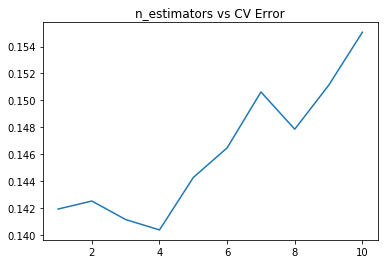

In [44]:
plt.plot(params, test_scores)
plt.title('n_estimators vs CV Error');

#### XGBoost

外号：Kaggle神器

这依旧是一款Boosting框架的模型，但是却做了很多的改进

In [46]:
from xgboost import XGBRegressor

In [47]:
params = [1,2,3,4,5,6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth=param) #每一颗树的深度
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

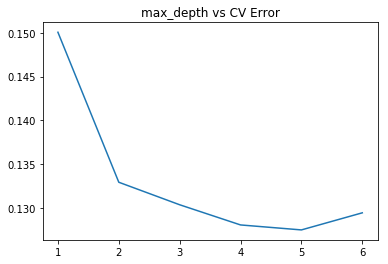

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("max_depth vs CV Error");